<a href="https://colab.research.google.com/github/Pullsu/Uczenie-maszynowe-w-finansach/blob/Notatki/UMwF_Wyk%C5%82ad_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08.04.2023

In [ ]:
# Importy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Dane
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

Sprawdź:

*   Liczbę wszystkich ocen
*   Liczbę filmów w bazie
*   Liczbę użytkowników
*   Średnią liczbę ocen na użytkownika
*   Średnią liczbę ocen na film
*   Rozkład ocen


In [ ]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Liczba wszystkich ocen
liczba_ocen = len(ratings['rating'])
liczba_ocen

# Liczba ocen wynosi 100836

100836

In [ ]:
# Liczba wszystkich filmów w bazie
liczba_filmow = len(movies['movieId'].unique())
liczba_filmow

# Liczba wszystkich filmów w bazie wynosi 9742

9742

In [ ]:
# Liczba użytkowników
liczba_uzytkownikow = len(ratings['userId'].unique())
liczba_uzytkownikow

# Liczba użytkowników wynosi 610

610

In [ ]:
# Średnia liczba ocen na użytkownika
srednia_liczba_ocen_na_uzytkownika = liczba_ocen/liczba_uzytkownikow
round(srednia_liczba_ocen_na_uzytkownika,2)

# Średnia liczba ocen na użytkownika wynosi 165.3

165.3

In [ ]:
# Średnia liczba ocena na film
srednia_liczba_ocen_na_film = liczba_ocen/liczba_filmow
round(srednia_liczba_ocen_na_film,2)

# Średnia liczba ocen na film wynosi 10.35

10.35

<ipython-input-30-aa1dc9427827>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


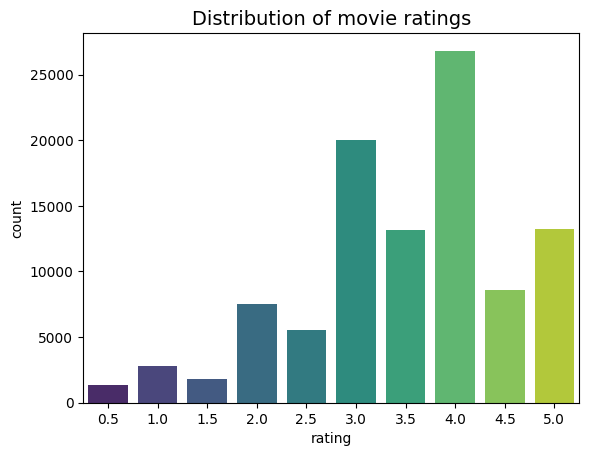

In [ ]:
# Rozkład ocen
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of movie ratings', fontsize=14)
plt.show()

Stwórz słowniki – zwracające tyluł filmu po
jego id

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [ ]:
#movie_titles

In [ ]:
# Zwykła średnia
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [ ]:
#movie_stats

In [ ]:
# Średnia bayesowska
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()
def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793
...,...,...,...,...
9719,193581,1,4.000000,3.327318
9720,193583,1,3.500000,3.283341
9721,193585,1,3.500000,3.283341
9722,193587,1,3.500000,3.283341


Przekształcenie danych - sparse matrix

In [ ]:
def create_sparse(df):

    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


System rekomendacji - KNN

In [ ]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Znajdź, 10 rekomendacji po obejrzeniu filmu: „Toy Story”


In [ ]:
toy_story_id = 1
rekomendacje_toy_story = find_similar_movies(toy_story_id, X, movie_mapper, movie_inv_mapper, 10)

In [ ]:
rekomendacje_toy_story

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [ ]:
print("Because you watched Toy Story we recommend you:")
for i in rekomendacje_toy_story:
    print(movie_titles[i])

Because you watched Toy Story we recommend you:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [ ]:
# Biblioteka SURPRISE wykorzystana w use_case_2

In [ ]:
# SURPRISE
!pip install surprise

# Importowanie relevant libraries
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset
from surprise import Reader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162982 sha256=75b698aef962e08a7c06adde43713212d58a783d0a358081b7790c4b2a376226
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [49]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [50]:
# Get minimum and maximum rating from the dataset
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader= Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [51]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8819  0.8726  0.8709  0.8739  0.8741  0.8747  0.0038  
MAE (testset)     0.6754  0.6701  0.6697  0.6726  0.6731  0.6722  0.0021  
Fit time          5.56    2.11    1.74    1.43    2.25    2.62    1.50    
Test time         0.36    0.49    0.13    0.27    0.20    0.29    0.12    


In [52]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
# print out the average RMSE score for the test set
print(np.mean(cv_knn_basic['test_rmse']))

0.9723313917176946
